In [1]:
import os
import gzip
import glob
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Proportion of recovered reads

In [2]:
dat = pd.read_excel("../../1_NanoStrandSeq/data/NanoStrandSeq.xls")
runs = ["20220708_GM12878",  "20220708_GM12878R2", "20220817_HG001", "20220915_P1","20220916_P1", "20220916_P2"]

rows = []
for run in runs:
    cells = dat[dat["Run"] == run]["Cell"].values
    
    row = []
    
    path = "../../1_NanoStrandSeq/results/demux/splitted/%s.log" % run
    vs = [int(x.split()[-2]) for x in filter(lambda line: "%" in line, open(path))]
    row.append(vs[0])
    row.append(vs[-1])
    
    trimmed = 0
    for cell in cells:
        path = "../../1_NanoStrandSeq/results/demux/trimmed/%s/%s.log" % (run, cell)
        vs = [int(x.split()[-2]) for x in filter(lambda line: "%" in line, open(path))]
        trimmed += vs[-1]
    row.append(trimmed)
    
    mapped = 0
    for cell in cells:
        path = "../../1_NanoStrandSeq/results/mapping/minimap2/%s/%s.flagstat" % (run, cell)
        for line in open(path):
            if "primary mapped" in line:
                mapped += int(line.split()[0])
    row.append(mapped)
    
    filtered = 0
    for cell in cells:
        path = "../../1_NanoStrandSeq/results/mapping/mark_duplicate/%s/%s.flagstat" % (run, cell)
        for line in open(path):
            if "primary mapped" in line:
                filtered += int(line.split()[0])
    row.append(filtered)
    
    rows.append(row)
    
d = pd.DataFrame(rows, index=runs, columns=["Raw", "Splitted", "Trimmed", "Mapped", "Filtered"])
d = d.divide(d["Raw"], axis=0) * 100

Raw         100.000000
Splitted     76.253493
Trimmed      69.612531
Mapped       69.252654
Filtered     65.335500
dtype: float64


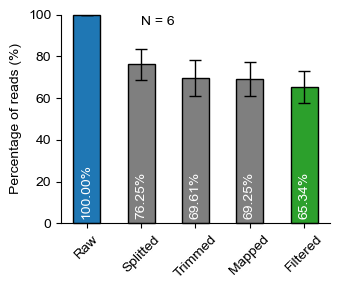

In [3]:
xs = np.arange(len(d.columns))
ys = d.mean(axis=0)
yerr = d.std(axis=0)
print(ys)

plt.figure(figsize=(3.5, 3))
plt.bar(xs, ys, edgecolor="black", color=["C0", "C7", "C7", "C7", "C2"], width=0.5, clip_on=False,
        yerr=yerr, error_kw={"capsize": 4, "lw": 1, "capthick": 1})
plt.text(1, 95, "N = %d" % len(d))
for x, y in zip(xs, ys):
    plt.text(x, 2, "%.2f%%" % y, color="white", rotation=90, va="bottom", ha="center")
plt.xticks(xs, [
    "Raw", 
    "Splitted",
    "Trimmed",
    "Mapped",
    "Filtered"
], rotation=45)
plt.ylim(0, 100)
plt.ylabel("Percentage of reads (%)")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
plt.savefig("figures/sequencing_yield.pdf", dpi=300)